Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

### different techniques such as bag of words,tfidf,avg-wordtovec,tfidf-w2v are employed to represent a review in vector notation in order to label it as positive or negative using different machine leqrning techniques.


## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [30]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [31]:
#append the path in which the required module is present to sys.path if path is not specied before
import sys
#sys.path.append('./.local/lib/python3.5/site-packages')
print(sys.path)


['/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '', '/home/iamlegendmailme/.local/lib/python3.5/site-packages', '/usr/local/lib/python3.5/dist-packages', '/usr/local/lib/python3.5/site-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.5/dist-packages/IPython/extensions', '/home/iamlegendmailme/.ipython']


In [3]:
#install the required package using this command if the required package is not installed in the kernel
#!pip3 install gensim

In [4]:

# using the SQLite Table to read data.this data set is used so that it would be easy to query upon the data
con = sqlite3.connect('database.sqlite') 
#here we only read revivews with rating that is either above or below zeroo since 3 is considered a neutral value
#a simple select query would do the task for us(so here we are using sqllite dataset instead of a csv file)

#filtered_data is a pandas data frame which will hold the positive and negative review data
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
#Here we are storing  the rating scores of the all the reviews in a variable
positiveNegative = actualScore.map(partition) 
#here we will convert rating to either '1' or '0' where 1 being positive and '0' being negative

filtered_data['Score'] = positiveNegative
#here we will update the score collumn with the changed rating values
print("Number of data points in our data", filtered_data.shape)
#here we will see all available features for us to solve the ml-problem

filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

Data Cleaning: Deduplication

here we check for duplicate entries and remove all of them from our data frame

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries--> here we will consider userid,profilename,time and also the text entered or the review 
#as the parametrers to remove thw duplicates
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

364k points are left after duplicate data points removal

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

only 69 % of the filtered data which is usable in the model is left

here helpfullness denominator should always be either equal or greater to the helpfullness denominator according to its function so we will remove all those type of data point which is not according to this principle as these points are invalid.

In [9]:
#an exaple for such type of points is 
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
#here we remove those points using a simple pandas comparision
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

as we can see the no of positive points are large almost 6 times bigger than the no of negative reviews

Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
# find sentences containing HTML tags
#we use regular expressions extensively for pattern matching
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;
#here each review is checked for the presence of html tag 

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [13]:
#use this if stop words are not downloaded in the ntlk package
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/iamlegendmailme/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer(words with same meaning)

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence) #here html words are replaced with spaces
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print("below list contains all stop words of nltk package")
print(stop)
print('************************************')
print(sno.stem('tasty'),"<--- this is the stem word of the word tasty.")

below list contains all stop words of nltk package
{'were', 'so', "mightn't", 'itself', 'whom', 'having', 'about', 'if', "you're", 'through', 'you', 'had', 'her', 'shan', 'his', 'will', 'any', 'yours', 'have', "doesn't", 'why', 'isn', 'down', 'there', 'theirs', 't', 'now', 'been', "that'll", 'herself', 'can', 'hadn', "don't", 'over', 'won', 'for', 'do', "you've", 'don', 'yourself', 'such', 'too', 'further', 'after', 'other', 'because', "won't", 'and', 'they', "should've", 'doing', 'when', 'weren', 'it', 'by', "haven't", 'she', 'to', 'ourselves', 'out', 'very', 'wasn', 'm', 'themselves', "hadn't", "weren't", 'each', 'above', 'the', 'in', "didn't", 'few', "wasn't", 'was', 'who', "you'd", 'these', "you'll", 'hasn', 'my', 'during', 'not', 'them', 'both', 've', 'mightn', 'which', 'below', 'wouldn', 'an', 'ours', 'o', 'your', 'is', 'be', 'from', 'between', 'on', 'mustn', 's', "isn't", 'are', "she's", "shan't", 'here', 'we', 'hers', 'should', 'their', 'this', 'under', 'll', 'shouldn', 'all', 

In [15]:
os.path.isfile('final.sqlite')

True

In [16]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences since no of reviews are around 364k
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);each review is stored in sent variable
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        #every valid word after stemmiing is appended into a list
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [32]:
#TO CHECK WHETHER OUR SQL FILE IS CREATED SUCCESSFULLY OR NOT
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please run the above cell")

In [33]:
#since the data is huge t-sne algos take longer time to compute so we will use 5000 data points
#half from positoive set and rest from negative set
data_positive = final[final["Score"] == 1].sample(n = 2500)
data_negative = final[final["Score"] == 0].sample(n = 2500)


In [34]:
#update the final variable with these 5000 data points
final = pd.concat([data_positive, data_negative])

here we will sort data frame according to the time such that we can split the data to train and test according to time

In [35]:
#sorting rows by the time at which reviews were given 
final =final.sort_values(by='Time')

In [36]:
#rating value (either positive or negative are stored in score variable)
score = final["Score"]
print(score.shape)
print(score.value_counts())


(5000,)
1    2500
0    2500
Name: Score, dtype: int64


# Bag of Words (BoW)

In [37]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
#Convert a collection of text documents to a matrix of token counts(changes each review into a vector)
#This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix
#which means a very huge sparse matrix is produced for each review using bag of words concept
final_counts = count_vect.fit_transform(final['CleanedText'].values)
#here words are changes into vectors
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 9820)
the number of unique words  9820


## Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews  and also changed tem into vector 
representation where we can use the power of linear algebra to analyze them further 

To find the frequently used words in both type of reviews

In [38]:
with open('positive_words.pkl', 'rb') as f:
    all_positive_words = pickle.load(f)#load the file again into the kernel
with open('negitive_words.pkl', 'rb') as f:
    all_negative_words = pickle.load(f)
    
freq_dist_positive=nltk.FreqDist(all_positive_words)
#this function calculates the words and their frequency in the corpus and stores them in a nltk object
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams) since many works can be simply used with not and the entire meaning will be changed just with one word.so, it will be better to use n bi grams instead of unigrams

In [39]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 141383)
the number of unique words including both unigrams and bigrams  141383


here we can see a huge increase in dimentions of the matrix when we use bigrams instaed of uni-grams

# TF-IDF

In [40]:
tf_idf_vect = TfidfVectorizer()
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
#with bigrams dimensions of the vector increases hugely ,so    t-sne takes huge space and time to compute 
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 9820)
the number of unique words including both unigrams and bigrams  9820


In [41]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100000:100010])

some sample features(unique words in the corpus) []


In [42]:

# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    #get the indexes of the top features
    top_feats = [(features[i], row[i]) for i in topn_ids]
    #get the names of those top features using indexes
    df = pd.DataFrame(top_feats)
    #put them in a data frames
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)
#get the first review and change it into vector form and sent it to the function

In [43]:
top_tfidf

,feature,tfidf
0,japanes,0.315494
1,cough,0.297763
2,medicin,0.281016
3,grape,0.279072
4,reaction,0.261980
5,children,0.254873
6,share,0.234320
7,gum,0.234320
8,entir,0.219412
9,flavor,0.217776





# [7.2.6] Word2Vec

In [44]:
# Using Google News Word2Vectors
#this is a state of the art technique which will help in create vectors which can retain semantic information
#Word2Vec (w2v) uses a shallow neural network to learn how words are used in a particular text corpus.
#The output of w2v is a matrix of vectors (think dataframe or Excel sheet), with each vector (column)
#representing a word in the corpus and providing a numerical description of how that word is used in context

# this is a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# else use a pickle file which contains a dict , 
# and it contains all amazon courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# source ::: http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g=True
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# print("the vector representation of word 'computer'",model.wv['computer'])
# print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
# print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

In [45]:
# Train your own Word2Vec model using your own text corpus (here we are using only 5000 reviews )
#each review will be broken into a word and stored in a list
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [46]:
print(len(list_of_sent))
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

5000
alway enjoy movi funni entertain didnt hesit pick clamshel edit guess market plan make movi famili someth elimin strong profan element usual edit televis version warn want uncut version avoid clamshel edit
*****************************************************************
['alway', 'enjoy', 'movi', 'funni', 'entertain', 'didnt', 'hesit', 'pick', 'clamshel', 'edit', 'guess', 'market', 'plan', 'make', 'movi', 'famili', 'someth', 'elimin', 'strong', 'profan', 'element', 'usual', 'edit', 'televis', 'version', 'warn', 'want', 'uncut', 'version', 'avoid', 'clamshel', 'edit']


In [47]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [48]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3360
sample words  ['heart', 'blue', 'lemon', 'adopt', 'feeder', 'burn', 'costco', 'cuisin', 'nestl', 'reaction', 'live', 'replac', 'francisco', 'gorgeous', 'construct', 'key', 'refil', 'suspect', 'sooner', 'assort', 'gumbal', 'greasi', 'junk', 'mad', 'plain', 'favorit', 'diet', 'gotta', 'primari', 'epa', 'newborn', 'dont', 'bean', 'equal', 'essenti', 'adult', 'browni', 'lamb', 'weekend', 'felin', 'reveal', 'tase', 'spend', 'worst', 'aliv', 'approv', 'sensat', 'bowel', 'forest', 'mulch']


In [49]:
w2v_model.wv.most_similar('tasti')

[('salti', 0.999245285987854),
 ('crunchi', 0.9988507032394409),
 ('crave', 0.9987400770187378),
 ('isnt', 0.9984949827194214),
 ('bake', 0.9984420537948608),
 ('lack', 0.9984387159347534),
 ('potato', 0.9984310865402222),
 ('strawberri', 0.9984254837036133),
 ('creami', 0.9983459711074829),
 ('over', 0.9979851245880127)]

In [50]:
w2v_model.wv.most_similar('like')

[('smell', 0.970767080783844),
 ('realli', 0.9699358940124512),
 ('tast', 0.9685978889465332),
 ('sweet', 0.9546635150909424),
 ('strong', 0.954232394695282),
 ('doesnt', 0.9531803727149963),
 ('flavor', 0.9482420682907104),
 ('artifici', 0.9454734325408936),
 ('bitter', 0.9373154640197754),
 ('butter', 0.9254043102264404)]

#  Avg W2V, TFIDF-W2V

In [51]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence#first 10000
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5000/5000 [00:08<00:00, 611.95it/s]

5000
50


In [52]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [53]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2 v for each sentence/review is stored in this list
row=0;
#list_of_sent_vec_10000=list_of_sent[1:10000]#taking only first 10000
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:09<00:00, 508.78it/s]


# K-NN ON BAG OF WORDS

In [54]:
#importing all required libraries
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

# here we split data based on the time other than random splitting

In [55]:
#splitting parameters
train_percentage_split = 0.7
count_row = final_counts.shape[0] 
no_of_rows_train = int(count_row*0.7)
no_of_rows_test = count_row - no_of_rows_train

In [77]:
#splitting the data into train and test
X_1 = final_counts[:no_of_rows_train]
X_test = final_counts[no_of_rows_train:]
y_1  = score[:no_of_rows_train]
y_test = score[no_of_rows_train:]
print("shape of train data  -->",X_1.shape,"shape of test data  -->",X_test.shape)
print(y_1.value_counts(),y_test.value_counts())

shape of train data  --> (3500, 9820) shape of test data  --> (1500, 9820)
1    1797
0    1703
Name: Score, dtype: int64 0    797
1    703
Name: Score, dtype: int64


In [78]:
#splitting training data into cross validation test and cross validation train.
percentage_cv_split=0.7
no_of_cv_train_rows = int(percentage_cv_split * no_of_rows_train)
no_of_cv_test_rows  = no_of_rows_train - no_of_cv_train_rows
#print(no_of_cv_train_rows ,no_of_cv_test_rows)
X_tr = X_1[:no_of_cv_train_rows]
X_cv = X_1[no_of_cv_train_rows:]
y_tr = y_1[:no_of_cv_train_rows]
y_cv = y_1[no_of_cv_train_rows:]

In [59]:
def run_knn(X_tr, y_tr,X_cv,y_cv,algo):
    for i in range(1,30,2):
        # instantiate learning model (k = 30)
        knn = KNeighborsClassifier(n_neighbors=i)

        # fitting the model on crossvalidation train
        knn.fit(X_tr, y_tr)

        # predict the response on the crossvalidation train
        pred = knn.predict(X_cv)

        # evaluate CV accuracy
        acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
        print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    


In [64]:
#with brute-force algorithm
run_knn(X_tr, y_tr,X_cv,y_cv,'brute')
knn = KNeighborsClassifier(11)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 11 is %d%%' % (acc))


CV accuracy for k = 1 is 58%

CV accuracy for k = 3 is 60%

CV accuracy for k = 5 is 63%

CV accuracy for k = 7 is 62%

CV accuracy for k = 9 is 63%

CV accuracy for k = 11 is 64%

CV accuracy for k = 13 is 64%

CV accuracy for k = 15 is 64%

CV accuracy for k = 17 is 63%

CV accuracy for k = 19 is 63%

CV accuracy for k = 21 is 62%

CV accuracy for k = 23 is 61%

CV accuracy for k = 25 is 61%

CV accuracy for k = 27 is 61%

CV accuracy for k = 29 is 61%

****Test accuracy for k = 11 is 62%


In [61]:
# so we get highest accuracy at k = 11 which is 66% and the test accuracy for that 'k' is 62%

In [65]:
#with brute-force algorithm
run_knn(X_tr, y_tr,X_cv,y_cv,'kd_tree')



CV accuracy for k = 1 is 58%

CV accuracy for k = 3 is 60%

CV accuracy for k = 5 is 63%

CV accuracy for k = 7 is 62%

CV accuracy for k = 9 is 63%

CV accuracy for k = 11 is 64%

CV accuracy for k = 13 is 64%

CV accuracy for k = 15 is 64%

CV accuracy for k = 17 is 63%

CV accuracy for k = 19 is 63%

CV accuracy for k = 21 is 62%

CV accuracy for k = 23 is 61%

CV accuracy for k = 25 is 61%

CV accuracy for k = 27 is 61%

CV accuracy for k = 29 is 61%


In [70]:
def knn_pred_with_test_data(k_var,X_tr,y_tr,X_test,y_test):
    knn = KNeighborsClassifier(k_var)
    knn.fit(X_tr,y_tr)
    pred = knn.predict(X_test)
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    print('\n****Test accuracy for k = ',k_var,' is %d%%' % (acc))

In [72]:
knn_pred_with_test_data(11,X_tr,y_tr,X_test,y_test)


****Test accuracy for k =  11  is 62%


# k-nn  using 10-fold cross validation 

In [89]:
# creating odd list of K for KNN
def ten_fold_knn(X_tr, y_tr):
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_tr, y_tr, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))


The optimal number of neighbors is 9.


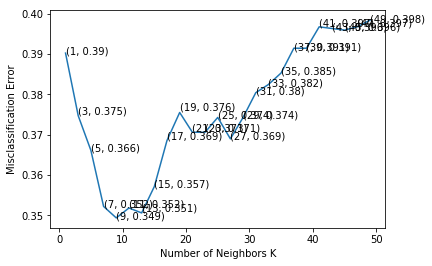

the misclassification error for each k value is :  [0.39  0.375 0.366 0.352 0.349 0.352 0.351 0.357 0.369 0.376 0.371 0.371
 0.374 0.369 0.374 0.38  0.382 0.385 0.391 0.391 0.397 0.396 0.396 0.397
 0.398]


In [79]:
ten_fold_knn(X_tr, y_tr)

from 10-fold , the optimal k- obtained is 9 and the accuracy obtained is 66% from the graph

In [73]:
knn_pred_with_test_data(9,X_tr,y_tr,X_test,y_test)


****Test accuracy for k =  9  is 62%


# K-NN ON tf-idf

In [86]:
#splitting the data into train and test
X_1 = final_tf_idf[:no_of_rows_train]
X_test = final_tf_idf[no_of_rows_train:]
X_tr = X_1[:no_of_cv_train_rows]
X_cv = X_1[no_of_cv_train_rows:]

In [87]:
#with brute-force algorithm
print( "with brute force algorithm")
run_knn(X_tr, y_tr,X_cv,y_cv,'brute')
print( "\nwith kd-tree algorithm")
run_knn(X_tr, y_tr,X_cv,y_cv,'kd-tree')

with brute force algorithm

CV accuracy for k = 1 is 59%

CV accuracy for k = 3 is 61%

CV accuracy for k = 5 is 64%

CV accuracy for k = 7 is 65%

CV accuracy for k = 9 is 65%

CV accuracy for k = 11 is 67%

CV accuracy for k = 13 is 68%

CV accuracy for k = 15 is 68%

CV accuracy for k = 17 is 69%

CV accuracy for k = 19 is 69%

CV accuracy for k = 21 is 69%

CV accuracy for k = 23 is 70%

CV accuracy for k = 25 is 72%

CV accuracy for k = 27 is 71%

CV accuracy for k = 29 is 72%

with kd-tree algorithm

CV accuracy for k = 1 is 59%

CV accuracy for k = 3 is 61%

CV accuracy for k = 5 is 64%

CV accuracy for k = 7 is 65%

CV accuracy for k = 9 is 65%

CV accuracy for k = 11 is 67%

CV accuracy for k = 13 is 68%

CV accuracy for k = 15 is 68%

CV accuracy for k = 17 is 69%

CV accuracy for k = 19 is 69%

CV accuracy for k = 21 is 69%

CV accuracy for k = 23 is 70%

CV accuracy for k = 25 is 72%

CV accuracy for k = 27 is 71%

CV accuracy for k = 29 is 72%


In [104]:
knn_pred_with_test_data(29,X_tr,y_tr,X_test,y_test)


****Test accuracy for k =  29  is 69%



The optimal number of neighbors is 43.


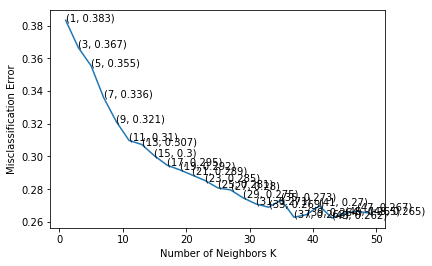

the misclassification error for each k value is :  [0.383 0.367 0.355 0.336 0.321 0.31  0.307 0.3   0.295 0.292 0.289 0.285
 0.281 0.28  0.275 0.271 0.269 0.273 0.263 0.264 0.27  0.262 0.265 0.267
 0.265]


In [99]:
#Ten-fold cv validation
ten_fold_knn(X_tr, y_tr)

In [105]:
knn_pred_with_test_data(43,X_tr,y_tr,X_test,y_test)


****Test accuracy for k =  43  is 70%


# K-NN  FOR AVG-W2V REPRESENTATION OF REVIEWS 

In [106]:
#splitting the data into train and test
X_1 = sent_vectors[:no_of_rows_train]
X_test = sent_vectors[no_of_rows_train:]
X_tr = X_1[:no_of_cv_train_rows]
X_cv = X_1[no_of_cv_train_rows:]

In [107]:
#with brute-force algorithm
print( "with brute force algorithm")
run_knn(X_tr, y_tr,X_cv,y_cv,'brute')
print( "\nwith kd-tree algorithm")
run_knn(X_tr, y_tr,X_cv,y_cv,'kd-tree')

with brute force algorithm

CV accuracy for k = 1 is 56%

CV accuracy for k = 3 is 56%

CV accuracy for k = 5 is 56%

CV accuracy for k = 7 is 57%

CV accuracy for k = 9 is 58%

CV accuracy for k = 11 is 59%

CV accuracy for k = 13 is 60%

CV accuracy for k = 15 is 58%

CV accuracy for k = 17 is 59%

CV accuracy for k = 19 is 59%

CV accuracy for k = 21 is 58%

CV accuracy for k = 23 is 58%

CV accuracy for k = 25 is 59%

CV accuracy for k = 27 is 60%

CV accuracy for k = 29 is 60%

with kd-tree algorithm

CV accuracy for k = 1 is 56%

CV accuracy for k = 3 is 56%

CV accuracy for k = 5 is 56%

CV accuracy for k = 7 is 57%

CV accuracy for k = 9 is 58%

CV accuracy for k = 11 is 59%

CV accuracy for k = 13 is 60%

CV accuracy for k = 15 is 58%

CV accuracy for k = 17 is 59%

CV accuracy for k = 19 is 59%

CV accuracy for k = 21 is 58%

CV accuracy for k = 23 is 58%

CV accuracy for k = 25 is 59%

CV accuracy for k = 27 is 60%

CV accuracy for k = 29 is 60%


In [ ]:
# here also both brute force and kd-tree are giving the similar results


The optimal number of neighbors is 45.


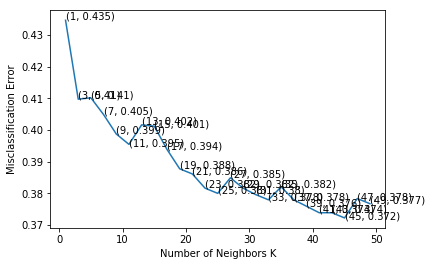

the misclassification error for each k value is :  [0.435 0.41  0.41  0.405 0.399 0.395 0.402 0.401 0.394 0.388 0.386 0.382
 0.38  0.385 0.382 0.38  0.378 0.382 0.378 0.376 0.374 0.374 0.372 0.378
 0.377]


In [108]:
#Ten-fold cv validation
ten_fold_knn(X_tr, y_tr)

In [113]:
knn_pred_with_test_data(45,X_tr,y_tr,X_test,y_test)


****Test accuracy for k =  45  is 60%


# K-NN FOR TF-IDF-W2V REPRESENTATION OF REVIEWS

In [114]:
#splitting the data into train and test
X_1 = tfidf_sent_vectors[:no_of_rows_train]
X_test = tfidf_sent_vectors[no_of_rows_train:]
X_tr = X_1[:no_of_cv_train_rows]
X_cv = X_1[no_of_cv_train_rows:]

In [115]:
#with brute-force algorithm
print( "with brute force algorithm")
run_knn(X_tr, y_tr,X_cv,y_cv,'brute')
print( "\nwith kd-tree algorithm")
run_knn(X_tr, y_tr,X_cv,y_cv,'kd-tree')

with brute force algorithm

CV accuracy for k = 1 is 54%

CV accuracy for k = 3 is 55%

CV accuracy for k = 5 is 58%

CV accuracy for k = 7 is 57%

CV accuracy for k = 9 is 58%

CV accuracy for k = 11 is 58%

CV accuracy for k = 13 is 59%

CV accuracy for k = 15 is 56%

CV accuracy for k = 17 is 57%

CV accuracy for k = 19 is 58%

CV accuracy for k = 21 is 58%

CV accuracy for k = 23 is 59%

CV accuracy for k = 25 is 59%

CV accuracy for k = 27 is 60%

CV accuracy for k = 29 is 58%

with kd-tree algorithm

CV accuracy for k = 1 is 54%

CV accuracy for k = 3 is 55%

CV accuracy for k = 5 is 58%

CV accuracy for k = 7 is 57%

CV accuracy for k = 9 is 58%

CV accuracy for k = 11 is 58%

CV accuracy for k = 13 is 59%

CV accuracy for k = 15 is 56%

CV accuracy for k = 17 is 57%

CV accuracy for k = 19 is 58%

CV accuracy for k = 21 is 58%

CV accuracy for k = 23 is 59%

CV accuracy for k = 25 is 59%

CV accuracy for k = 27 is 60%

CV accuracy for k = 29 is 58%


#HERE BOTH ALGOS GAVE SIMILAR RESULT WITH HIGHEST ACCURACY OF 60%


The optimal number of neighbors is 49.


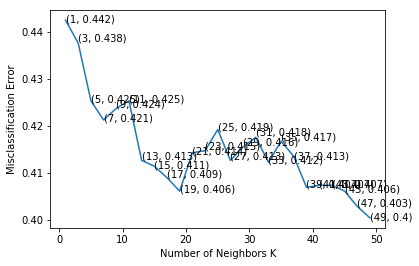

the misclassification error for each k value is :  [0.442 0.438 0.425 0.421 0.424 0.425 0.413 0.411 0.409 0.406 0.414 0.415
 0.419 0.413 0.416 0.418 0.412 0.417 0.413 0.407 0.407 0.407 0.406 0.403
 0.4  ]


In [116]:
#Ten-fold cv validation
ten_fold_knn(X_tr, y_tr)

In [118]:
knn_pred_with_test_data(49,X_tr,y_tr,X_test,y_test)


****Test accuracy for k =  49  is 57%


observations:
    1)Both the algoriths brute force and kd-tree gave almost same result when applied k-nn using all 
    four representations(BOW,TF-IDF,AVG-W2V,TF-W2V).
    2)k obtained using 10-fold validations are very nearer to the k's found using normal validation.
    3)test accuracy for all type of representations lies almost in (65-72%) range .
    4)since accuracies are getting stagnated after 50 without changing much even for very higher k's ,
    we can say that data is pretty random and cannot be decided on any decision surface.
    5)since accuracies are are below 70% we cannot stronly rely on this model to predict preview types.